In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

from statsmodels.tsa.stattools import acf

from statsmodels.tsa.seasonal import STL

Nós podemos criar várias features de diferentes time series.

### 1.0. Some simple statistics

Qualquer valor sumarizado estatístico de uma time series é uma feature desta time series.
Podemos computar algumas estatisticas simples como o min, max, media, mediana, std e os quartis.

In [2]:
df = pd.read_csv("../data/tourism.csv", index_col=[0])
df['Quarter'] = df.Quarter.apply(lambda x: x.replace(' ', '-'))
df['Quarter'] = pd.PeriodIndex(df.Quarter, freq='Q').to_timestamp()

In [3]:
df.iloc[:, 1:].describe().T

,count,mean,std,min,25%,50%,75%,max
Trips,24320.0,70.896448,118.763185,0.0,7.22391,28.134538,78.15441,985.278401


In [4]:
df.iloc[:, 1:].groupby(["Region", "State", "Purpose"]).agg(
    min=("Trips", "min"),
    std=("Trips", "std"),
    p25=("Trips", lambda x: x.quantile(0.25)),
    median=("Trips", "median"),
    mean=("Trips", "mean"),
    p75=("Trips", lambda x: x.quantile(0.75)),
    max=("Trips", "max"),
)

min        std         p25   
Region          State           Purpose                                       
Adelaide        South Australia Business   68.725393  35.646424  133.893462  \
                                Holiday   108.033040  27.063233  134.626822   
                                Other      25.901846  17.340788   43.865901   
                                Visiting  136.611154  32.499407  178.915998   
Adelaide Hills  South Australia Business    0.000000   4.296483    0.000000   
...                                              ...        ...         ...   
Wimmera         Victoria        Visiting    1.307505   7.462415   10.800154   
Yorke Peninsula South Australia Business    0.000000   5.084377    3.161881   
                                Holiday    34.078872  26.145673   58.180385   
                                Other       0.000000   2.245611    0.500451   
                                Visiting    8.041249  10.093017   21.608759   

                                              median        mean         p75   
Region          State           Purpose                                        
Adelaide        South Australia Business  152.576618  155.527910  176.935536  \
                                Holiday   153.945007  156.543437  172.256676   
                                Other      53.809463   56.563450   62.523135   
                                Visiting  205.581736  205.193667  229.299111   
Adelaide Hills  South Australia Business    1.255434    2.664236    3.920368   
...                                              ...         ...         ...   
Wimmera         Victoria        Visiting   13.863049   14.879986   19.222546   
Yorke Peninsula South Australia Business    5.727692    6.892481    9.023333   
                                Holiday    77.624339   80.088485   96.779303   
                                Other       1.288070    1.885884    2.789666   
                                Visiting   26.970494   28.146552   34.052298   

                                                 max  
Region          State           Purpose               
Adelaide        South Australia Business  242.494368  
                                Holiday   223.557406  
                                Other     107.494657  
                                Visiting  269.535618  
Adelaide Hills  South Australia Business   28.601515  
...                                              ...  
Wimmera         Victoria        Visiting   42.516814  
Yorke Peninsula South Australia Business   23.062615  
                                Holiday   138.035726  
                                Other      13.903678  
                                Visiting   56.202511  

[304 rows x 7 columns]

### 2.0. ACF Features

Todas as correlações da série são consideradas features, podemos computar estatisticas dessas features também.
Outras features como os lags, diferenciações, e diferenças sazonais.

No R existe o proprio feat_acf que computa as features, no python temos que criar manualmente cada uma das seguintes features:

- the first autocorrelation coefficient from the original data;
- the sum of squares of the first ten autocorrelation coefficients from the original data;
- the first autocorrelation coefficient from the differenced data;
- the sum of squares of the first ten autocorrelation coefficients from the differenced data;
- the first autocorrelation coefficient from the twice differenced data;
- the sum of squares of the first ten autocorrelation coefficients from the twice differenced data;
- For seasonal data, the autocorrelation coefficient at the first seasonal lag is also returned.

In [5]:
df.iloc[:, 1:].groupby(["Region", "State", "Purpose"]).agg(
    m_diff=("Trips", lambda x: np.mean(x.diff())),
    m_shift=("Trips", lambda x: np.mean(x.shift(12))),

    acf1=("Trips", lambda x: acf(x, nlags=1)[-1]),
    acf10=("Trips", lambda x: np.sum(acf(x, nlags=10)[1:] ** 2)),

    diff1_acf1=("Trips", lambda x: acf(x.diff().dropna(), nlags=1)[-1]),
    diff1_acf10=("Trips", lambda x: np.sum(acf(x.diff().dropna(), nlags=10)[1:] ** 2)),
    
    diff2_acf1=("Trips", lambda x: acf(x.diff().dropna().diff().dropna(), nlags=1)[-1]),
    diff2_acf10=("Trips", lambda x: np.sum(acf(x.diff().dropna().diff().dropna(), nlags=10)[1:] ** 2)),

    season_lag=("Trips", lambda x: acf(x, nlags=4)[1:][-1])
)

m_diff     m_shift      acf1   
Region          State           Purpose                                        
Adelaide        South Australia Business  7.873710e-01  152.421674  0.033271  \
                                Holiday  -1.203082e-01  152.763019  0.045570   
                                Other     2.074132e-01   52.761073  0.516806   
                                Visiting -4.970173e-02  200.580771  0.068365   
Adelaide Hills  South Australia Business  2.248553e-17    2.477407  0.070915   
...                                                ...         ...       ...   
Wimmera         Victoria        Visiting -2.117683e-02   14.609721  0.157781   
Yorke Peninsula South Australia Business -8.987760e-02    7.241974  0.031072   
                                Holiday  -4.379969e-02   79.472947 -0.005010   
                                Other    -5.680239e-02    1.576464 -0.107388   
                                Visiting  1.767974e-01   27.046150  0.067882   

                                             acf10  diff1_acf1  diff1_acf10   
Region          State           Purpose                                       
Adelaide        South Australia Business  0.130646   -0.519622     0.462537  \
                                Holiday   0.371898   -0.342625     0.614365   
                                Other     1.153598   -0.408620     0.382891   
                                Visiting  0.294237   -0.393654     0.452291   
Adelaide Hills  South Australia Business  0.134473   -0.579504     0.414537   
...                                            ...         ...          ...   
Wimmera         Victoria        Visiting  0.081974   -0.394069     0.233051   
Yorke Peninsula South Australia Business  0.118294   -0.404626     0.299658   
                                Holiday   2.012741   -0.144431     2.060254   
                                Other     0.149484   -0.633766     0.622122   
                                Visiting  0.196162   -0.352026     0.419349   

                                          diff2_acf1  diff2_acf10  season_lag  
Region          State           Purpose                                        
Adelaide        South Australia Business   -0.676429     0.741357    0.200875  
                                Holiday    -0.486833     0.558244    0.351151  
                                Other      -0.675120     0.792353    0.341781  
                                Visiting   -0.517959     0.447296    0.344930  
Adelaide Hills  South Australia Business   -0.750404     0.746004   -0.062808  
...                                              ...          ...         ...  
Wimmera         Victoria        Visiting   -0.631235     0.519578    0.009476  
Yorke Peninsula South Australia Business   -0.558642     0.385050    0.218628  
                                Holiday    -0.256017     1.570939    0.578856  
                                Other      -0.689203     0.779006    0.160689  
                                Visiting   -0.524002     0.455819    0.225135  

[304 rows x 9 columns]

<Axes: xlabel='Quarter'>

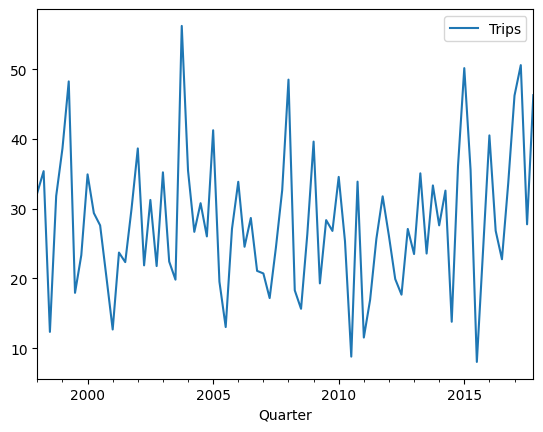

In [6]:
df[(df["Region"] == "Yorke Peninsula") & (df["Purpose"] == "Visiting")].plot(x="Quarter", y="Trips")

<Axes: xlabel='Quarter'>

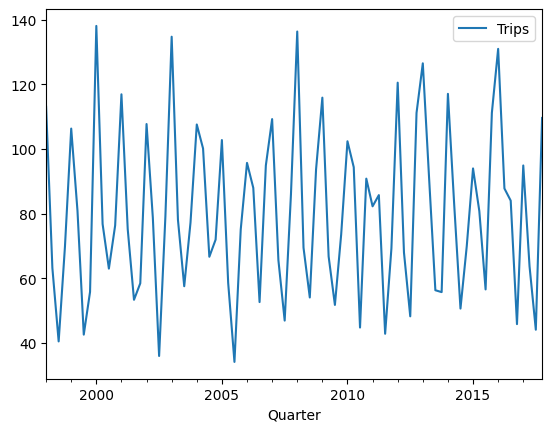

In [7]:
df[(df["Region"] == "Yorke Peninsula") & (df["Purpose"] == "Holiday")].plot(x="Quarter", y="Trips")

### 3.0. STL Features

A decomposição também é base para mais algumas features, ela pode ser usada para medir a força da tendência e da sazonalidade.

Na decomposição, conseguimos obter os três componentes, a tendencia, sazonalidade e o restante.

Para dados com tendência fortes, os dados ajustados sazonalmente (seasonal adjusted data) deverão ter uma variação muito maior do que o componente restante, caso contrario, nenhuma variação, podemos definir isso matematicamente como:

$F_T = max(0, 1 - \frac{Var(R_t)}{Var(T_t + R_t)})$

Podemos ajustar a formula e obter a força da sazonalidade também.

$F_S = max(0, 1 - \frac{Var(R_t)}{Var(S_t + R_t)})$


Ambas as fórmula nos entrega a força da tendência e da sazonalidade que varia entre 0 e 1.

Irei definir essas funções em python e gerar elas com o pandas groupby.

In [8]:
def fit_stl(
    s: pd.Series,
    period: int = 12,
    seasonal: int = 11
) -> tuple[np.array, np.array, np.array]:

    # Precisamos fazer um fine tuning no STL 
    # Antes de gerar essas features!
    stl = STL(
        s, 
        robust=True, 
        period=period,     # Periodos Sazonais
        seasonal=seasonal, # Smoothing
    )

    components = stl.fit()

    trend = components.trend
    resid = components.resid
    seasn = components.seasonal

    return resid, trend, seasn

def feat_stl_ft(s: pd.Series, period: int = 12, seasonal: int = 11) -> float:
    resid, trend, _ = fit_stl(s, period, seasonal)
    return max(0, 1 - (np.var(resid) / np.var((trend + resid))))

def feat_stl_fs(s: pd.Series, period: int = 12, seasonal: int = 11) -> float:
    resid, _, seasn = fit_stl(s, period, seasonal)
    return max(0, 1 - (np.var(resid) / np.var((seasn + resid))))

def feat_stl(s: pd.Series, period: int = 12, seasonal: int = 11) -> float:
    resid, trend, seasn = fit_stl(s, period, seasonal)

    ft = max(0, 1 - (np.var(resid) / np.var((trend + resid))))
    fs = max(0, 1 - (np.var(resid) / np.var((seasn + resid))))

    return ft, fs

In [29]:
feats = df.iloc[:, 1:].groupby(["Region", "State", "Purpose"]).agg(
    ft=("Trips", lambda x: feat_stl_ft(x, period=4, seasonal=3)),
    fs=("Trips", lambda x: feat_stl_fs(x, period=4, seasonal=3))
).reset_index()

feats

,Region,State,Purpose,ft,fs
0,Adelaide,South Australia,Business,0.866561,0.963686
1,Adelaide,South Australia,Holiday,0.966103,0.988869
2,Adelaide,South Australia,Other,0.827382,0.800129
3,Adelaide,South Australia,Visiting,0.945699,0.981917
4,Adelaide Hills,South Australia,Business,0.714556,0.917917
...,...,...,...,...,...
299,Wimmera,Victoria,Visiting,0.885667,0.965775
300,Yorke Peninsula,South Australia,Business,0.909942,0.980725
301,Yorke Peninsula,South Australia,Holiday,0.700779,0.985605
302,Yorke Peninsula,South Australia,Other,0.968223,0.987131


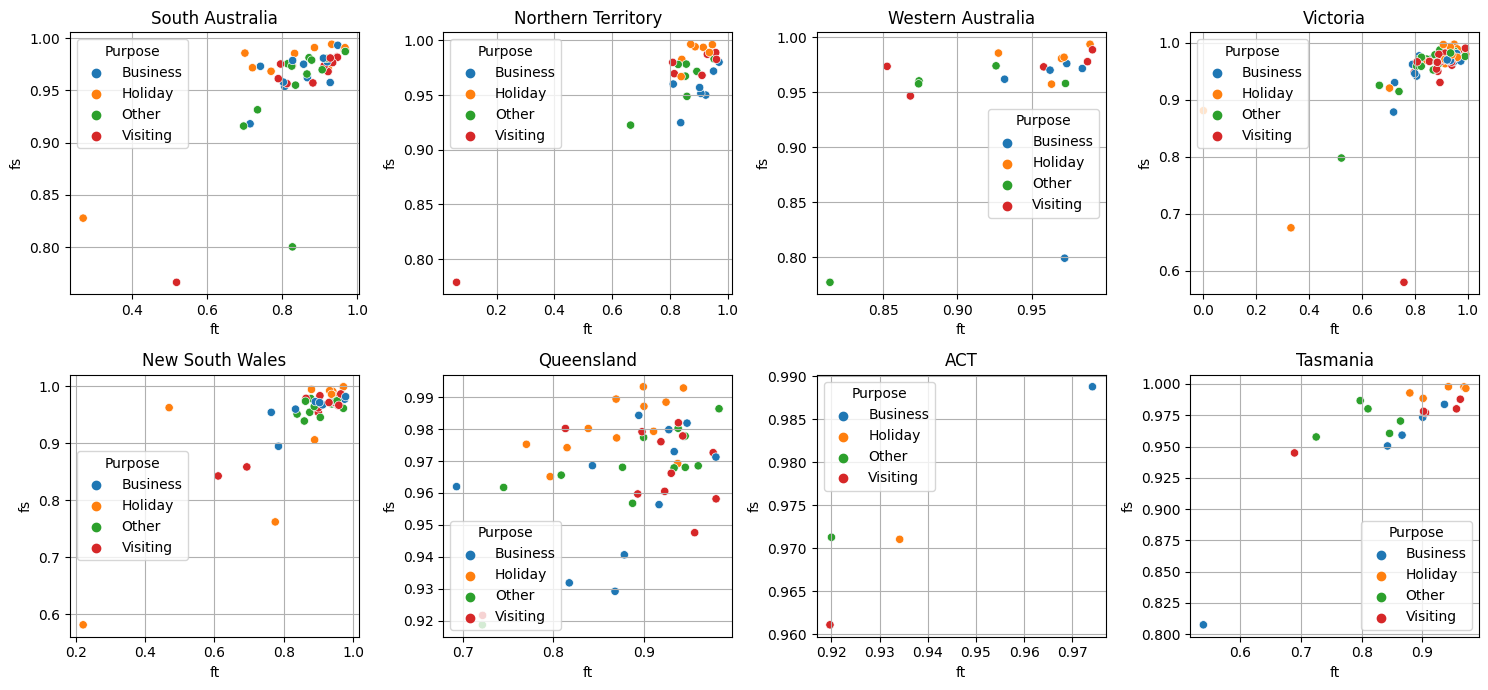

In [54]:
fig, ax = plt.subplots(2, 4, figsize=(15, 7))
ax = ax.flatten()

for state, axi in zip(feats.State.unique(), ax):
    dfs = feats[feats.State == state]
    ss = sns.scatterplot(dfs, x="ft", y="fs", hue="Purpose", ax=axi, legend=True)

    axi.set_title(f"{state}")
    axi.grid(2)

plt.tight_layout()

Parece que o STL não deu conta do serviço. O Holidays deveria ser o principal.

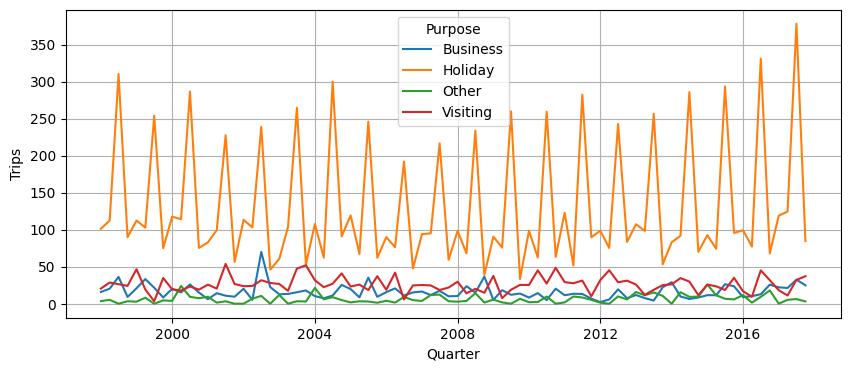

In [66]:
fig, ax = plt.subplots(figsize=(10,4))
sns.lineplot(
    df[(df["Region"] == "Snowy Mountains") & (df["State"] == "New South Wales")],
    x="Quarter", y="Trips", hue="Purpose"
);
ax.grid(2);

Existem outras features calculadas que o feat_stl que o livro cita mas não detalha.

### 4.0. Other Features

Existem outras inumeras features calculadas que o livro cita, infelizmente algumas não existem no python e outras vão ser abordadas mais a frente no livro, outras o livro cita mas não detalha.